# 1.1 2-D Building initial
### This is a notebook for simulating the seismic wave propagation in 2D Building, and it is initially from the Salvus homepage, with the web link:
https://salvus.io/examples/Jupytext/geotech/buildings/buildings/
#### .............................................................................................
#### Edited by Salvus group of ETH (https://salvus.io/)
#### .............................................................................................

In [1]:
# Magic
%autosave 0
%matplotlib inline
%config Completer.use_jedi = False

Autosave disabled


The vedio of the snapshot can be seen in wedb link
https://www.youtube.com/watch?v=y86aHBDUeFY&feature=youtu.be

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import salvus_flow.simple_config as config
import salvus_toolbox.toolbox as st
import salvus_toolbox.toolbox_geotech as st_geo
from salvus_flow import api

## Generating the mesh
To generate our idealized building we'll use a function internal to the Salvus toolbox -- if you're curious how it works, you could take a look at the get_simple_building function we've imported above. The function takes a variety of values which parameterize how the mesh is generated. The values below produce a 50 "story" building with a basement foundation. As with the rest of Salvus, all units are SI.

In [3]:
n_stories = 50
wall_width = 1.0
story_height = 3.0
ceiling_height = 0.3
building_width = 20.0
basement_depth = 20.0
basement_width = 50.0

Before we generate the mesh itself we need to set a few values which determine the resolution of the resulting simulation. For a more detailed discussion on the proper values to choose here, please see one of the other tutorials, such as the "Marmousi" tutorial. Below we'll assume a constant shear-wave velocity value of 1500 m/s, and, using this as the minimum velocity in the mesh, mesh the domain so that we have at least 2 elements per wavelength assuming a maximum frequency of 500 Hz.

In [4]:
f_max = 500.0        # Maximum frequency of the wavelet
vs_min = 1500.0
nelem_per_wavelength = 2.0

Now its time to build the mesh itsef. Below we pass the requisite parameters to the generation function, and receive back a the tuple: (mesh, bnd). The first entry here is indeed our mesh -- we'll plot it in a few cells -- and the bnd value represents the minimum distance to which the mesh was extruded to attach absorbing boundary layers. This value will be helpful later when we're setting up the simulation.

In [5]:
mesh, bnd = st_geo.get_simple_building(
    f_max=f_max,
    vs_min=vs_min,
    n_stories=n_stories,
    wall_width=wall_width,
    story_height=story_height,
    basement_width=basement_width,
    basement_depth=basement_depth,
    building_width=building_width,
    ceiling_height=ceiling_height,
    nelem_per_wavelength=nelem_per_wavelength,
)

In [6]:
nodes = mesh.get_element_nodes()[:, :, 0]
mesh.attach_field("RHO", np.ones_like(nodes) * 1000)
mesh.attach_field("VS", np.ones_like(nodes) * vs_min)
mesh.attach_field("VP", np.ones_like(nodes) * vs_min * 2)

In [7]:
# With our parameters attached, we can now plot the model below.
mesh

## Setting up the simulation

Here we set up a simple source to inject some energy for the upcoming simulation. We use here a Ricker source-time function with a center frequency which is half the maximum frequency in the mesh. More information on the available source-time functions and source types can be found in the relevant tutorials.

In [8]:
# Setting the source time function (stf)
stf = config.stf.Ricker(center_frequency=f_max / 2)
source = config.source.cartesian.VectorPoint2D(
    x=-20, y=0.0, fx=1.0, fy=1.0, source_time_function=stf
)

Now we set up an array of 100 sensors which will travel up the left wall of our building. In addition to setting the spatial locations for each receiver, we'll also tell Salvus to output the velocity and gradient of displacement at each spatial location.

In [9]:
n_rec = 100      # number of recievers
x_rec = np.ones(n_rec) * -building_width / 2     #Location of the receivers along x (horizontal) direction
y_rec = np.linspace(0, n_stories * story_height, n_rec) #Location of the receivers along y (vertical) direction
receivers = [
    config.receiver.cartesian.Point2D(
        x=x,
        y=y,
        station_code=f"{_i:03d}",
        fields=["velocity", "gradient-of-displacement"],                  
    )
    for _i, (x, y) in enumerate(zip(x_rec, y_rec))
]
# The output field can be: "velocity", "gradient-of-displacement","displacement","acceleration",
# "strain", "phi", "phi_t", "phi_tt", and "gradient-of-phi"

In [10]:
# Initialize with sources and receivers.
w = config.simulation.Waveform(mesh=mesh, sources=source, receivers=receivers)

# Set end time, start time is automatically determined.
w.physics.wave_equation.end_time_in_seconds = 0.1

# Define and attach our absorbing boundaries.
ab = config.boundary.Absorbing(
    side_sets=["x0", "x1", "y0"], width_in_meters=bnd, taper_amplitude=f_max
)
w.physics.wave_equation.boundaries = [ab]

# Use simplified HDF5 source output.
w.output.point_data.format = "hdf5"

# Save the volumetric wavefield for visualization purposes.     This is for the vedio of the snapshot
# w.output.volume_data.format = "hdf5"
# w.output.volume_data.filename = "output.h5"
# w.output.volume_data.fields = ["displacement"]
# w.output.volume_data.sampling_interval_in_time_steps = 10

# Ensure that Salvus will accept our parameters.
w.validate()

# Plot the mesh with the sources and receivers.
w

With everything defined, plotting the simulation.Waveform() object gives us a visual representation of where our sources and sensors were placed. As expected, we've instrumented the left wall with a series of velocity / gradient sensors, and placed a source just outside the building.

## Running the simulation
Running the simulation is as simple as calling the api.run command as below. This simulation is rather small, so running on 2 ranks locally should allow for the simulation to complete within 10 - 30 seconds. Of course for bigger simulations (or simulations in 3D) we could install Salvus on a remote supercomputing site. In this case, none of the above workflow would change, and all we would do is specify the remote site for our site_name below. Salvus Flow would take care of shuttling data to and from the remote machine as required.

In [11]:
api.run(
    ranks=2,
    get_all=True,
    input_file=w,
    overwrite=True,
    site_name="local",
    output_folder="output",
)

Job `job_1908282017202463_b58f8754ed` running on `local` with 2 rank(s).
Site information:
  * Salvus version: 0.10.0
  * Floating point size: 32



* Downloaded 17.4 MB of results to `output`.
* Total run time: 9.16 seconds.
* Pure simulation time: 7.67 seconds.


## Analyzing the results
Below we plot a "shotgather" showing the output of the displacement gradient sensors we placed along the left wall of the building. While informative in their own right, such results could be used to also investigate the rotational motion recorded at each sensor if desired.

Text(0.5, 0, 'y (m)')

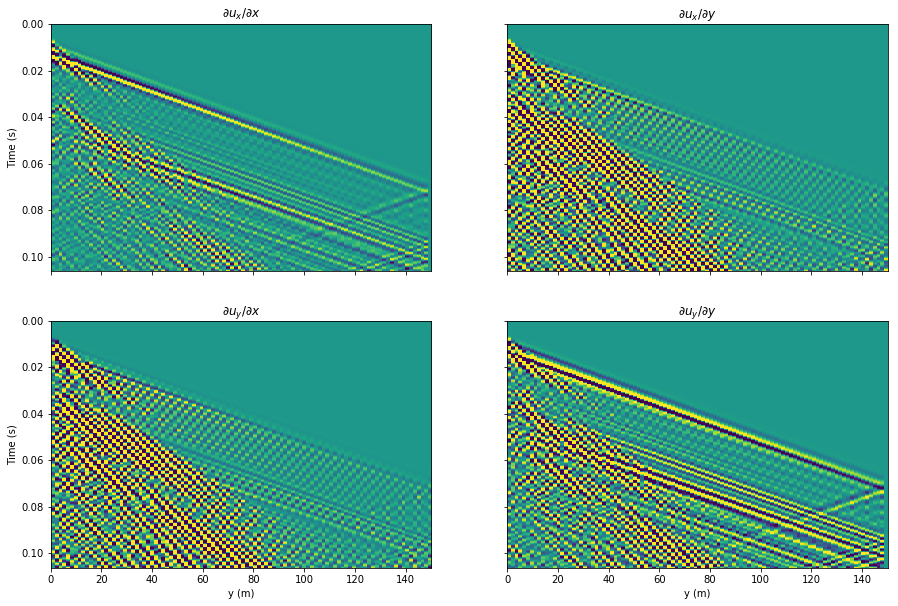

In [12]:
f, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Read in data.
rec_file = "output/receivers.h5"
field = "gradient-of-displacement"
uxx, dt, extent = st.get_shotgather(rec_file, field=field, cmp=0, axis=1)
uxy, _, _ = st.get_shotgather(rec_file, field=field, cmp=1, axis=1)
uyx, _, _ = st.get_shotgather(rec_file, field=field, cmp=2, axis=1)
uyy, _, _ = st.get_shotgather(rec_file, field=field, cmp=3, axis=1)

# Normalize and plot the shotgather.
uxx_min, uxx_max = 0.1 * uxx.min(), 0.1 * uxx.max()
uxy_min, uxy_max = 0.1 * uxy.min(), 0.1 * uxy.max()
uyx_min, uyx_max = 0.1 * uyx.min(), 0.1 * uyx.max()
uyy_min, uyy_max = 0.1 * uyy.min(), 0.1 * uyy.max()

# Plot the different fields.
ax[0, 0].imshow(uxx, vmin=uxx_min, vmax=uxx_max, extent=extent, aspect="auto")
ax[0, 1].imshow(uxy, vmin=uxx_min, vmax=uxx_max, extent=extent, aspect="auto")
ax[1, 0].imshow(uyx, vmin=uxx_min, vmax=uxx_max, extent=extent, aspect="auto")
ax[1, 1].imshow(uyy, vmin=uxx_min, vmax=uxx_max, extent=extent, aspect="auto")

# Label plots
ax[0, 0].set_title(r"$\partial u_x / \partial x$")
ax[0, 1].set_title(r"$\partial u_x / \partial y$")
ax[1, 0].set_title(r"$\partial u_y / \partial x$")
ax[1, 1].set_title(r"$\partial u_y / \partial y$")

# Label axes.
ax[0, 0].set_ylabel("Time (s)")
ax[1, 0].set_ylabel("Time (s)")
ax[1, 0].set_xlabel("y (m)")
ax[1, 1].set_xlabel("y (m)")